# Машинное обучение. Полуфинал для студентов бакалавриата и магистратуры.

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

# магические команды
%matplotlib inline 

In [2]:
SUB_NUMBER = 0

def submit(prediction): # функция для выгрузки решения
    global SUB_NUMBER
    SUB_NUMBER += 1
    submission = pd.read_csv(r'data/Empty_part.csv')
    submission['NTG'] = prediction  
    with open(f'solutions/{SUB_NUMBER}.csv', 'w') as f:
        submission.to_csv(f, index=False)
    return f'Submission comlited ({SUB_NUMBER})'

In [3]:
def RMSE(predictions, y_val): # функция для вывода RMSE
    baseline = np.ones(shape=(predictions.shape)) * y_val.mean()
    print(f'RMSE: {np.sqrt(mean_squared_error(y_val, predictions))}')
    print(f'Baseline RMSE: {np.sqrt(mean_squared_error(y_val, baseline))}')

In [4]:
# загрузка данных
train = pd.read_csv(r'data/Training_wells.csv')
test = pd.read_csv(r'data/Empty_part.csv')

In [5]:
# оценка количества данных: train в 9 раз меньше test
print(f'train shape: {train.shape}')
print(f'test shape:  {test.shape}')

train shape: (138, 4)
test shape:  (1242, 3)


In [6]:
# столбец well - комбинация столбцов X и Y
train.head()

,Well,X,Y,NTG
0,201-907,201,907,0.2006
1,201-914,201,914,0.3624
2,201-924,201,924,0.4381
3,202-922,202,922,0.4289
4,202-925,202,925,0.4021


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Well    138 non-null    object 
 1   X       138 non-null    int64  
 2   Y       138 non-null    int64  
 3   NTG     138 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.4+ KB


In [8]:
# все элементы столбца Well уникальны в обеих выборках, а значит можно использовать этот столбец как уникальный идентификатор для каждой скважины
print(train.Well.nunique())
print(test.Well.nunique())

138
1242


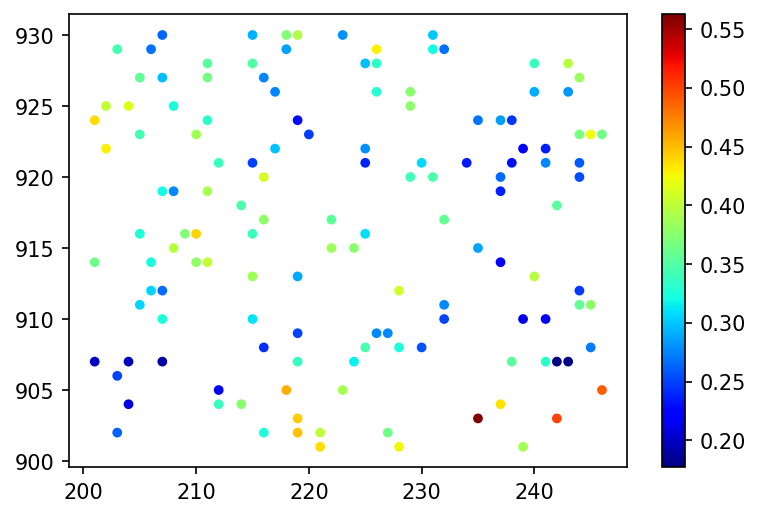

In [9]:
# отрисовка данных
plt.figure(dpi = 150)
plt.scatter(train.X, train.Y, cmap = 'jet', c = train.NTG, marker='o', lw = 0.8, s = 15)
plt.colorbar()

In [10]:
# вычислим среднее по столбцу NTG
train['NTG'].mean()

0.3257195652173913

<AxesSubplot:xlabel='NTG', ylabel='Count'>

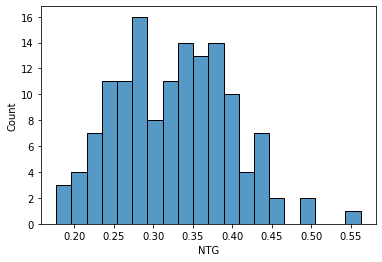

In [11]:
# построим гистограмму распределения NTG
sns.histplot(train['NTG'], bins=20)

In [12]:
# убедимся, что NTG признак имеет близкое к нормальному распределение
k2, p = stats.normaltest(train.NTG)
alpha = 5 * 1e-2
if p >= alpha:
    print('Approximately normal distribution. p = {:.5f}'.format(p))

Approximately normal distribution. p = 0.42945


In [13]:
# все элементы из train.Y есть в test.Y
print(set(train.Y).issubset(set(test.Y))) # все ли элементы из test есть в train
print(set(test.Y).issubset(set(train.Y))) # все ли элементы из train есть в test

True
True


In [14]:
# не все элементы из train.X есть в test.X, а именно 213, 233, 236 нет в train.X.
# В таком случае есть вероятность, что признаки сгенерированные на основе столбца не будут репрезентативны

print(set(train.X).issubset(set(test.X))) # все ли элементы из test есть в train
print(set(test.X).issubset(set(train.X))) # все ли элементы из train есть в test

print(set(test.X).symmetric_difference(set(train.X)))

True
False
{213, 233, 236}


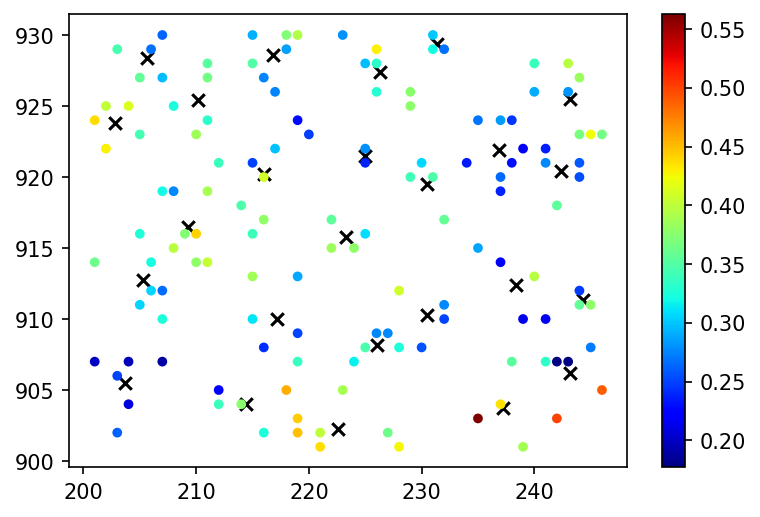

In [15]:
# Сделаем предплоожение: пусть у скважин, которые находятся рядом, будут примерно одинаковые значения NTG. 
# Тогда, если объединить такие скважины в кластеры, а затем на в каждом кластере посчитать какие-либо статистические параметры 
# (минимум, максимум, среднее и медиану, например). Эти параметры затем можно добавить к выборкам.

# В нагрузку можно посчитать статистические параметры вдоль осей.

kmeans_seed = 1
kmeans = KMeans(n_clusters=25, random_state=kmeans_seed)
kmeans.fit(train[['X', 'Y']])

# визуализация кластеров
plt.figure(dpi = 150)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='black')
plt.scatter(train.X, train.Y, cmap = 'jet', c = train.NTG, marker='o', lw = 0.8, s = 15)
plt.colorbar()

In [16]:
train['cluster'] = kmeans.labels_
 
train_gen = train.copy()
test_gen = test.copy()
test_gen['cluster'] = kmeans.predict(test[['X', 'Y']]) 

# добавляем нужные фичи к нашим данным
for column in ('X', 'Y', 'cluster'):
    for agtype in ('min', 'max','mean', 'median'):
        group = train_gen.groupby(by=column).agg({'NTG':agtype})
        group.reset_index(inplace=True)
        group.columns = [column, f'NTG {column} {agtype}']
            
        train_gen = pd.merge(train_gen, group, on=column, how='left')
        test_gen = pd.merge(test_gen, group, on=column, how='left')

In [17]:
train_gen.head()

,Well,X,Y,NTG,cluster,NTG X min,NTG X max,NTG X mean,NTG X median,NTG Y min,NTG Y max,NTG Y mean,NTG Y median,NTG cluster min,NTG cluster max,NTG cluster mean,NTG cluster median
0,201-907,201,907,0.2006,11,0.2006,0.4381,0.3337,0.3624,0.1770,0.3534,0.253744,0.20060,0.1897,0.2628,0.218567,0.2049
1,201-914,201,914,0.3624,0,0.2006,0.4381,0.3337,0.3624,0.2244,0.4042,0.338780,0.36240,0.2659,0.3624,0.316329,0.3228
2,201-924,201,924,0.4381,19,0.2006,0.4381,0.3337,0.3624,0.2287,0.4381,0.300033,0.27735,0.3431,0.4381,0.405160,0.4136
3,202-922,202,922,0.4289,19,0.4021,0.4289,0.4155,0.4155,0.2189,0.4289,0.292440,0.27940,0.3431,0.4381,0.405160,0.4136
4,202-925,202,925,0.4021,19,0.4021,0.4289,0.4155,0.4155,0.3244,0.4136,0.379375,0.38975,0.3431,0.4381,0.405160,0.4136


In [18]:
# В признаках, полученных на основе Х, появились пропуски в test. Потому что, в train выборке отсутствовала часть значений {213, 233, 236}
test_gen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1242 entries, 0 to 1241
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Well                1242 non-null   object 
 1   X                   1242 non-null   int64  
 2   Y                   1242 non-null   int64  
 3   cluster             1242 non-null   int32  
 4   NTG X min           1152 non-null   float64
 5   NTG X max           1152 non-null   float64
 6   NTG X mean          1152 non-null   float64
 7   NTG X median        1152 non-null   float64
 8   NTG Y min           1242 non-null   float64
 9   NTG Y max           1242 non-null   float64
 10  NTG Y mean          1242 non-null   float64
 11  NTG Y median        1242 non-null   float64
 12  NTG cluster min     1242 non-null   float64
 13  NTG cluster max     1242 non-null   float64
 14  NTG cluster mean    1242 non-null   float64
 15  NTG cluster median  1242 non-null   float64
dtypes: flo

<AxesSubplot:>

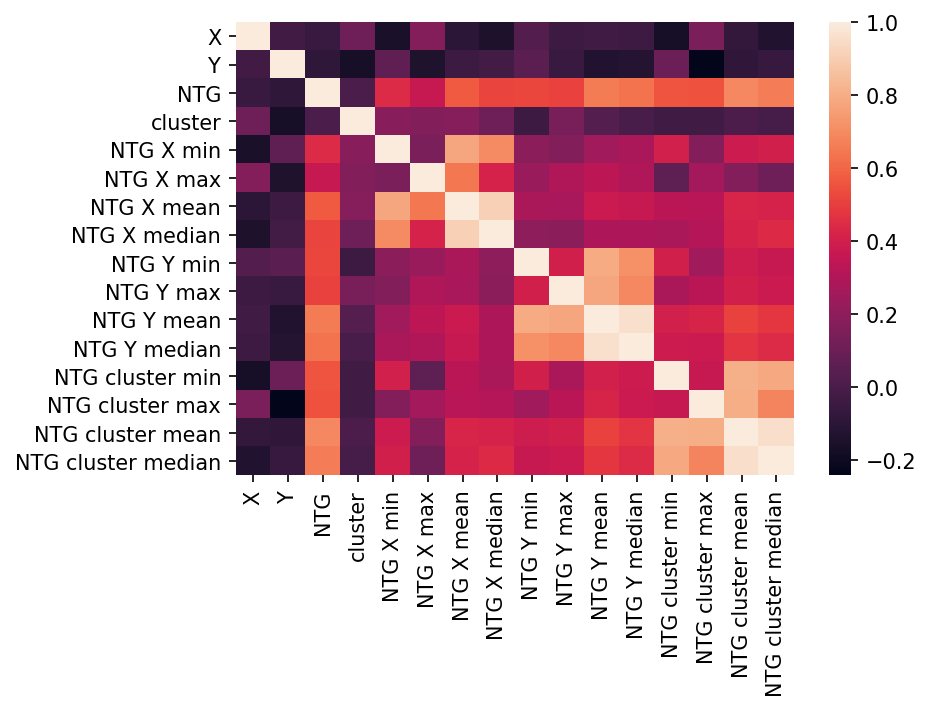

In [19]:
# рассмотрим корреляцию признаков. Судя по диаграмме с NTG лучше остальных коррелирует NTG cluster mean.
plt.figure(dpi = 150)
sns.heatmap(train_gen.corr())

__Посылка №1__

_время:_ 2 мрт 2021 22:48:20

_id:_ 49082786

In [20]:
# Для начала возмем базовые фичи: коодринаты и номер кластера. Модель: градиентный бустинг деревьев решений.
features = ['X','Y','cluster']

x_train, x_val, y_train, y_val = train_test_split(train_gen[features],
                                                  train_gen['NTG'],
                                                  test_size=0.2, random_state=35)

model = XGBRegressor(objective='reg:squarederror')

model.fit(x_train, y_train)
predictions = model.predict(x_val)

RMSE(predictions, y_val)

predictions = model.predict(test_gen[features])
submit(predictions)

RMSE: 0.047498531395447685
Baseline RMSE: 0.057707924309068896


'Submission comlited (1)'

__Посылка №2__

_время:_ 2 мрт 2021, 22:50:38

_id:_ 49082892

In [21]:
# Возьмем все фичи, кроме тех, что сгенерированы по X. Модель: линейная регрессия.
features = ['X','Y','cluster',
            'NTG Y min', 'NTG Y max', 'NTG Y mean', 'NTG Y median',
            'NTG cluster min', 'NTG cluster max', 'NTG cluster mean', 'NTG cluster median']

x_train, x_val, y_train, y_val = train_test_split(train_gen[features],
                                                  train_gen['NTG'],
                                                  test_size=0.2,
                                                  random_state=35)

linear = LinearRegression()

linear.fit(x_train, y_train)
predictions = linear.predict(x_val)

RMSE(predictions, y_val)

predictions = linear.predict(test_gen[features])
submit(predictions)

RMSE: 0.03310874853618287
Baseline RMSE: 0.057707924309068896


'Submission comlited (2)'

__Посылка №3__

_время:_ 2 мрт 2021, 22:51:24

_id:_ 49082915

In [22]:
# Найдем лучшую комбинацию фич, используя жадный алгоритм. Лучше всего себя показала комбинация NTG Y mean и NTG cluster mean.
train_for_greedy = train_gen.copy()
X = train_for_greedy.drop(['Well', 'NTG', 'NTG X min',
                                  'NTG X max',
                                  'NTG X mean',
                                  'NTG X median'], axis=1).copy()
y = train_for_greedy['NTG'].copy()

features_names = X.columns
logs = {}
    
for n_columns in range(1, features_names.shape[0]+1):
        
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=35)
        
    lr = LinearRegression()
    selector = RFE(lr, n_features_to_select=n_columns, step=1).fit(x_train, y_train)
        
    selected_columns = list(features_names[selector.support_])
        
    lr.fit(x_train[selected_columns], y_train)
    predictions = lr.predict(x_val[selected_columns])
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
        
    log_name = f'{n_columns} features'
    logs[log_name] = [selected_columns, rmse]

for name in logs.keys():
    print(f"{name}:")
    print(*logs[name][0], sep=',')
    print(logs[name][1], end='\n\n')

1 features:
NTG cluster mean
0.03195041310538391

2 features:
NTG Y mean,NTG cluster mean
0.030146574585717505

3 features:
NTG Y mean,NTG Y median,NTG cluster mean
0.030581264726821426

4 features:
NTG Y min,NTG Y mean,NTG Y median,NTG cluster mean
0.030934357582470335

5 features:
NTG Y min,NTG Y max,NTG Y mean,NTG Y median,NTG cluster mean
0.03225033530546156

6 features:
NTG Y min,NTG Y max,NTG Y mean,NTG Y median,NTG cluster min,NTG cluster mean
0.032634237799302

7 features:
NTG Y min,NTG Y max,NTG Y mean,NTG Y median,NTG cluster min,NTG cluster mean,NTG cluster median
0.03276036579773643

8 features:
NTG Y min,NTG Y max,NTG Y mean,NTG Y median,NTG cluster min,NTG cluster max,NTG cluster mean,NTG cluster median
0.033118017847402564

9 features:
Y,NTG Y min,NTG Y max,NTG Y mean,NTG Y median,NTG cluster min,NTG cluster max,NTG cluster mean,NTG cluster median
0.033057949151010034

10 features:
X,Y,NTG Y min,NTG Y max,NTG Y mean,NTG Y median,NTG cluster min,NTG cluster max,NTG cluste

In [23]:
features = ['NTG Y mean', 'NTG cluster mean']
x_train, x_val, y_train, y_val = train_test_split(train_gen[features],
                                                  train_gen['NTG'],
                                                  test_size=0.2,
                                                  random_state=35)

linear = LinearRegression()

linear.fit(x_train, y_train)
predictions = linear.predict(x_val)

RMSE(predictions, y_val)
predictions = linear.predict(test_gen[features])
submit(predictions)

RMSE: 0.030146574585717505
Baseline RMSE: 0.057707924309068896


'Submission comlited (3)'